In [1]:
from __future__ import print_function

from tensorflow import keras
import numpy as np
import pandas as pd

ImportError: DLL load failed while importing _multiarray_umath: No se puede encontrar el módulo especificado.

In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


df = pd.read_csv('features_50_filt.csv')

# Extraer las columnas relevantes para las ventanas
feature_columns = [col for col in df.columns if 'window' in col]

# Convertir el DataFrame a un array de numpy y reorganizar a formato 3D
# n_samples será el número de filas en df
# n_windows se calcula a partir de cuántas veces aparece cada tipo de característica
# n_features_per_window es la cantidad de características por ventana
n_samples = df.shape[0]
n_windows = len(set(col.split('_')[-1] for col in feature_columns))  # Número de ventanas únicas
n_features_per_window = len(feature_columns) // n_windows  # Características por ventana

data_3d = df[feature_columns].values.reshape((n_samples, n_windows, n_features_per_window))

In [5]:
data_3d.shape

(656, 55, 11)

In [6]:
# Convertir la columna 'glaucoma' en etiquetas binarias
y = df['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0).values

In [7]:
from sklearn.model_selection import train_test_split

# Divide en 80% entrenamiento y 20% prueba
x_train_val, x_test, y_train_val, y_test = train_test_split(data_3d, y, test_size=0.2, random_state=26)

# Divide el conjunto de entrenamiento en 80% entrenamiento y 20% validación
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=26)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_reshaped = x_train.reshape(-1, x_train.shape[-1])  # Aplanar para aplicar el escalador
x_train_reshaped = scaler.fit_transform(x_train_reshaped)
x_train = x_train_reshaped.reshape(x_train.shape)  # Volver a la forma original

x_val_reshaped = x_val.reshape(-1, x_val.shape[-1])  # Aplanar para aplicar el escalador
x_val_reshaped = scaler.transform(x_val_reshaped)
x_val = x_val_reshaped.reshape(x_val.shape)  # Volver a la forma original

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# Definir el modelo
model = Sequential()
model.add(GRU(64, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))  # Activación sigmoide para clasificación binaria

# Compilar el modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Configurar el callback para guardar el mejor modelo
checkpoint = ModelCheckpoint('GRU_caract_model_1.h5', monitor='val_loss', 
                             save_best_only=True, mode='min', verbose=1)

# Configurar la reducción de la tasa de aprendizaje
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                                              patience=50, min_lr=0.0001)


# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_val, y_val), callbacks = [checkpoint, reduce_lr])

Epoch 1/100
26/27 [===========================>..] - ETA: 0s - loss: 0.6806 - accuracy: 0.5361
Epoch 1: val_loss improved from inf to 0.65505, saving model to GRU_caract_model_1.h5
27/27 [==============================] - 7s 100ms/step - loss: 0.6808 - accuracy: 0.5370 - val_loss: 0.6551 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/100
24/27 [=========================>....] - ETA: 0s - loss: 0.6601 - accuracy: 0.6042
Epoch 2: val_loss did not improve from 0.65505
27/27 [==============================] - 1s 22ms/step - loss: 0.6606 - accuracy: 0.5990 - val_loss: 0.6689 - val_accuracy: 0.5429 - lr: 0.0010
Epoch 3/100
25/27 [==========================>...] - ETA: 0s - loss: 0.6553 - accuracy: 0.5875
Epoch 3: val_loss did not improve from 0.65505
27/27 [==============================] - 0s 15ms/step - loss: 0.6592 - accuracy: 0.5823 - val_loss: 0.6624 - val_accuracy: 0.5429 - lr: 0.0010
Epoch 4/100
25/27 [==========================>...] - ETA: 0s - loss: 0.6600 - accuracy: 0.6000
Epoch 4: v

In [11]:
model = keras.models.load_model('GRU_caract_model_1.h5')

In [12]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

5/5 [==============================] - 1s 6ms/step - loss: 0.7505 - accuracy: 0.4773
Test Accuracy: 0.48


In [13]:
val_loss, val_accuracy = model.evaluate(x_val, y_val)
print(f"val Accuracy: {val_accuracy:.2f}")

4/4 [==============================] - 0s 6ms/step - loss: 0.6518 - accuracy: 0.6190
val Accuracy: 0.62


5/5 [==============================] - 1s 10ms/step
Test Accuracy: 0.48
4/4 [==============================] - 0s 10ms/step
Validation Accuracy: 0.62


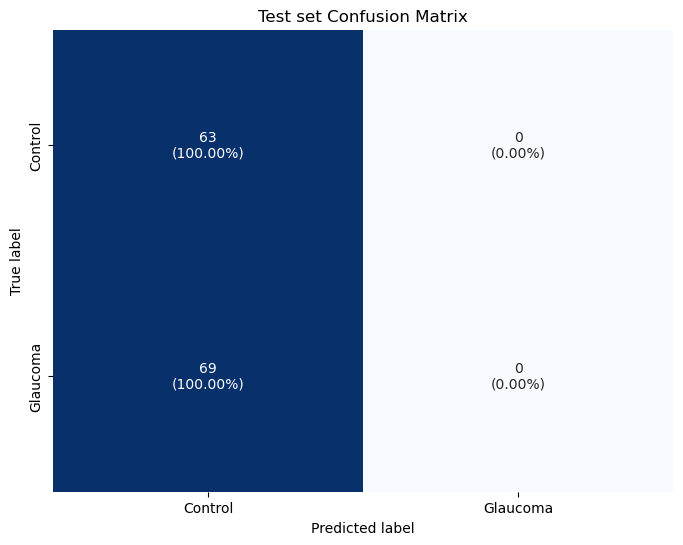

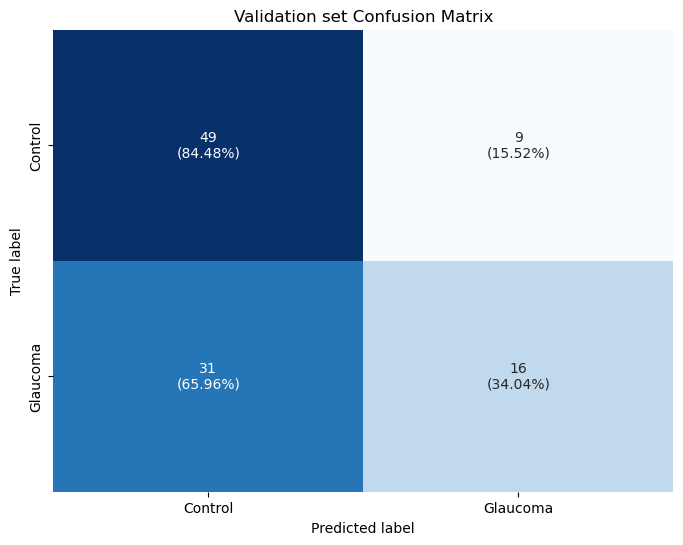

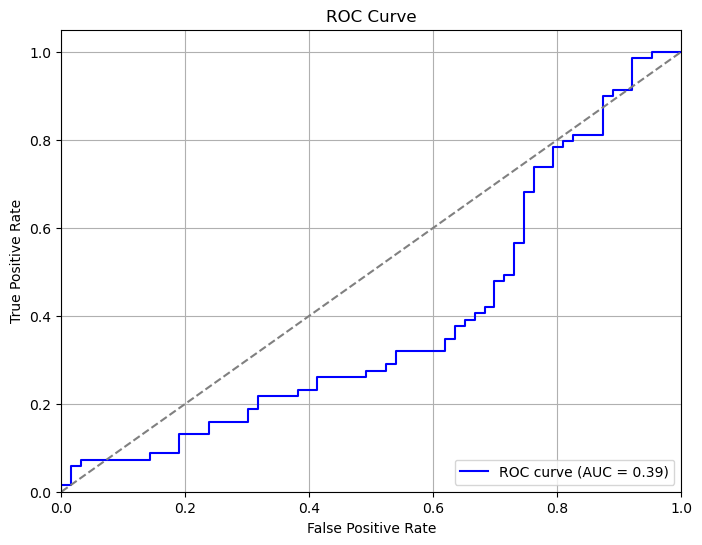

AUC: 0.39


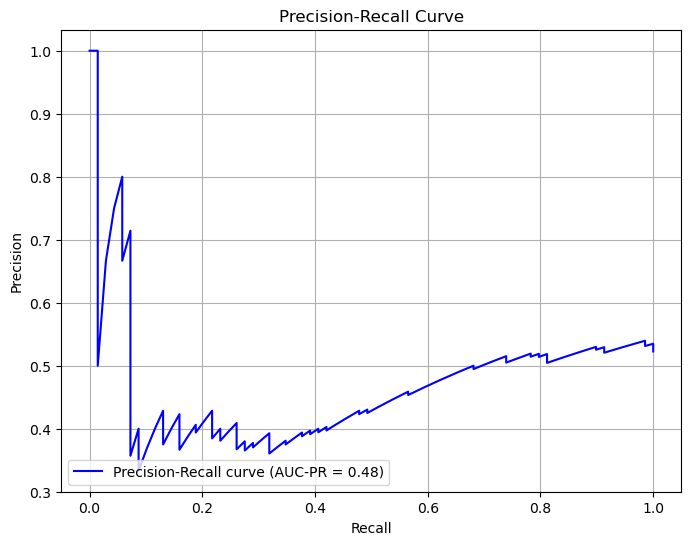

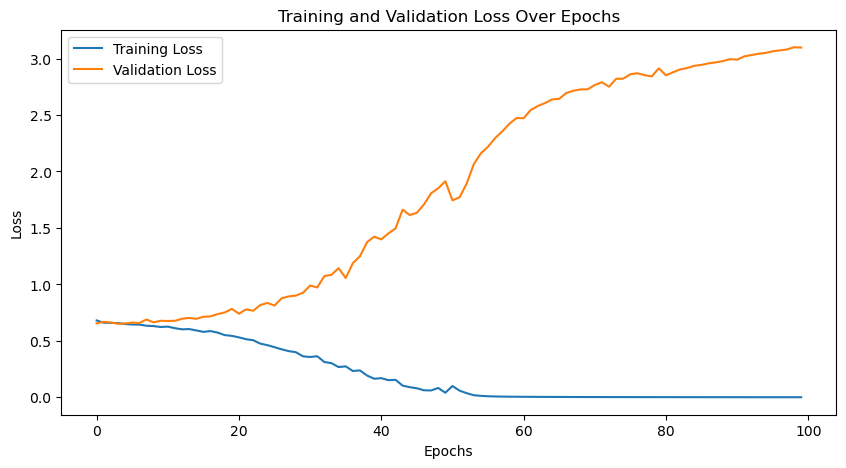

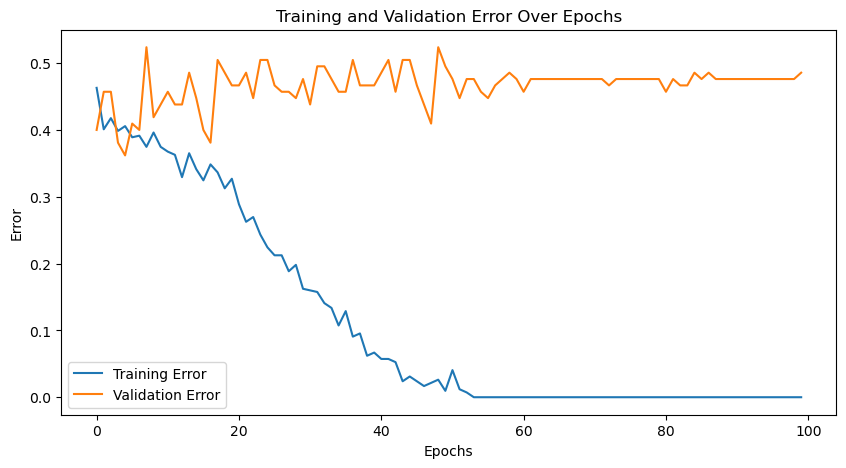

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score

# Convertir el historial de entrenamiento en un DataFrame para facilitar el análisis
log = pd.DataFrame(history.history)

# Realizar las predicciones en el conjunto de prueba
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convertir las probabilidades en etiquetas de clase (0 o 1)

# Calcular el accuracy en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {accuracy:.2f}")

# Realizar las predicciones en el conjunto de validación
y_val_pred = model.predict(x_val)
y_val_pred_classes = (y_val_pred > 0.5).astype(int).flatten()  # Convertir las probabilidades en etiquetas de clase

# Calcular el accuracy en el conjunto de validación
val_accuracy = accuracy_score(y_val, y_val_pred_classes)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Calcular y graficar la matriz de confusión para el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_pred_classes)
conf_matrix_normalized = confusion_matrix(y_test, y_pred_classes, normalize='true')
labels = np.asarray([f'{int(conf_matrix[i, j])}\n({conf_matrix_normalized[i, j]:.2%})' 
                     for i in range(conf_matrix.shape[0]) 
                     for j in range(conf_matrix.shape[1])]).reshape(conf_matrix.shape)

class_names = ['Control', 'Glaucoma']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Test set Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calcular y graficar la matriz de confusión para el conjunto de validación
conf_matrix = confusion_matrix(y_val, y_val_pred_classes)
conf_matrix_normalized = confusion_matrix(y_val, y_val_pred_classes, normalize='true')
labels = np.asarray([f'{int(conf_matrix[i, j])}\n({conf_matrix_normalized[i, j]:.2%})' 
                     for i in range(conf_matrix.shape[0]) 
                     for j in range(conf_matrix.shape[1])]).reshape(conf_matrix.shape)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Validation set Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calcular la curva ROC y el AUC para el conjunto de prueba
y_prob = y_pred.flatten()  # Asegúrate de que sea la probabilidad de la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_value = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC: {auc_value:.2f}")

# Calcular la curva Precision-Recall y el AUC-PR
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AUC-PR = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Graficar las pérdidas a lo largo de las épocas
plt.figure(figsize=(10, 5))
plt.plot(log['loss'], label='Training Loss')
plt.plot(log['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Calcular y graficar el error a lo largo de las épocas
train_error = 1 - log['accuracy']
val_error = 1 - log['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(train_error, label='Training Error')
plt.plot(val_error, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Error Over Epochs')
plt.legend()
plt.show()